In [ ]:
# permisos para acceder a googleDrive
from google.colab import drive
drive.mount('/content/drive')

In [26]:
import os

drive_folder = 'drive/MyDrive/TESIS/'

# Definición de la base de datos
data_folder = drive_folder + 'db/data/'
image_folder = drive_folder + 'db/images/cow/'
shape_folder = drive_folder + 'db/images/shape/'

# si no da error es que se cargaron bien
files = os.listdir(image_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os
import torch
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [31]:
image_folder = image_folder  # Directorio de entrada con imágenes
pretrained = True  # Utilizar pesos preentrenados del modelo
resize_input = 256  # Tamaño de redimensionamiento de la entrada
crop_size = 224  # Tamaño de recorte centrado
mean = [0.485, 0.456, 0.406]  # Media para la normalización
std = [0.229, 0.224, 0.225]  # Desviación estándar para la normalización

In [47]:
import torchvision.models.segmentation as segmentation_models
available_models = dir(segmentation_models)
available_models = [
  'DeepLabV3',
  'DeepLabV3_MobileNet_V3_Large_Weights',
  'DeepLabV3_ResNet101_Weights',
  'DeepLabV3_ResNet50_Weights',
  'FCN',
  'FCN_ResNet101_Weights',
  'FCN_ResNet50_Weights',
  'LRASPP',
  'LRASPP_MobileNet_V3_Large_Weights',
  'deeplabv3',
  'deeplabv3_mobilenet_v3_large',
  'deeplabv3_resnet101',
  'deeplabv3_resnet50',
  'fcn',
  'fcn_resnet101',
  'fcn_resnet50',
  'lraspp',
  'lraspp_mobilenet_v3_large'
]

model_name = "lraspp_mobilenet_v3_large"  # Nombre del modelo a utilizar (ej. "fcn_resnet50")

In [48]:
# Cargar modelo
model_fn = getattr(models.segmentation, model_name)
model = model_fn(pretrained=pretrained)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=LRASPP_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/lraspp_mobilenet_v3_large-d234d4ea.pth" to /root/.cache/torch/hub/checkpoints/lraspp_mobilenet_v3_large-d234d4ea.pth
100%|██████████| 12.5M/12.5M [00:00<00:00, 50.9MB/s]


LRASPP(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1

In [49]:
# Transformaciones necesarias para la entrada del modelo
transform = T.Compose([
    T.Resize(resize_input),
    T.CenterCrop(crop_size),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

In [50]:
# Función para segmentar la imagen
def segment_image(image):
    input_image = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(input_image)['out']
    output_predictions = output.argmax(1)[0]
    return output_predictions

# Función para aplicar la máscara segmentada y extraer la región de interés
def extract_region(image, mask):
    # Obtener las dimensiones originales de la imagen
    original_size = image.size

    # Redimensionar la máscara para que coincida con las dimensiones originales de la imagen
    mask_resized = mask.byte().cpu().numpy()
    mask_resized = Image.fromarray(mask_resized).resize(original_size, resample=Image.NEAREST)
    mask_resized = np.array(mask_resized)

    # Convertir la imagen y la máscara a numpy arrays
    image_np = np.array(image)

    # Multiplicar la imagen por la máscara para extraer la región de interés
    extracted_image = image_np * np.expand_dims(mask_resized, axis=2)

    # Convertir el resultado de vuelta a un objeto de imagen y devolverlo
    return Image.fromarray(extracted_image.astype(np.uint8))

In [51]:
def preprocess_image(image_name):
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        image_path = os.path.join(image_folder, image_name)
        image = Image.open(image_path).convert("RGB")

        # Segmentar la imagen
        mask = segment_image(image)

        # Extraer la región de interés (vaca en este caso)
        extracted_image = extract_region(image, mask)

        # Mostrar el resultado
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(image)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(extracted_image)
        ax[1].set_title('Extracted Region')
        ax[1].axis('off')

        plt.show()

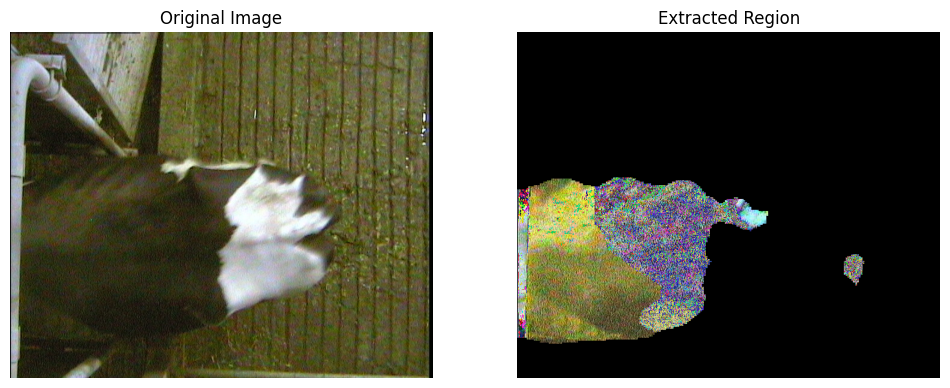

In [52]:
image_list = os.listdir(image_folder)
preprocess_image(image_list[0])

In [ ]:
# Procesar cada imagen en el directorio
for image_name in os.listdir(image_folder):
   preprocess_image(image_name)
